In [2]:
%matplotlib inline

In [29]:
import numpy as np
from nighres import io, surface
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt
import pickle
from nipype.interfaces import fsl
from glob import glob
import os

In [4]:
def jo2allen_vol(data):
    data = np.swapaxes(np.swapaxes(data, 0,1), 1,2)
    data = np.flip(np.flip(data,1),0)
    return data

#### Make levelset from tight cortex mask (derived from layer masks)

In [ ]:
lvl=surface.probability_to_levelset("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz")
lvl['result'].to_filename("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

In [4]:
lvl = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

In [11]:
nb.save(nb.Nifti1Image(np.asarray(lvl.get_data(), dtype='float32'), np.eye(4)), 
        "/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

#### Downsample levelset to 200 um

In [ ]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   apply_isoxfm=0.2,
                   interp="spline",
                   out_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl_200um.nii.gz")
resamp.run()

#### Bring original data in 200 um into allen space

In [ ]:
# extract info from example image
img = nb.load("/home/julia/data/gradients/orig/sub-jgrAesMEDISOc11L_ses-1_task-rest_acq-EPI_run-1_bold.nii.gz")
data = img.get_data()
shape_allen = jo2allen_vol(data[:,:,:,0]).shape
num_vol = data.shape[3]

aff = np.eye(4)*0.2
aff[3,3]=1

hdr = nb.Nifti1Header()
hdr['dim']=np.array([4, shape_allen[0], shape_allen[1], shape_allen[2], num_vol, 
                     1, 1, 1], dtype='int16')
hdr['pixdim']=img.header['pixdim']


# load each image, transform and save
func = glob("/home/julia/data/gradients/orig/*MEDISO*EPI*.nii.gz")

for f in func:
    data_allen = np.zeros((shape_allen[0], shape_allen[1], shape_allen[2], num_vol))
    data_jo = nb.load(f).get_data()
    
    for vol in range(num_vol):
        data_allen[:,:,:,vol] = jo2allen_vol(data_jo[:,:,:,vol])

    nb.save(nb.Nifti1Image(data_allen, aff, hdr),
            "/home/julia/data/gradients/orig_allen/%s_allen.nii.gz" % os.path.basename(f).split(".")[0])

#### Load mesh

In [9]:
mesh = io.load_mesh_geometry("/home/julia/data/gradients/atlas/allen_api/brain_mesh.vtk")

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2444: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2447: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


(-0.5, 56.5, 39.5, -0.5)

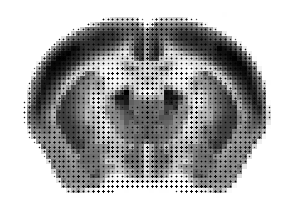

In [61]:
x = 30
fig = plt.figure(figsize=(5,5))
mesh_slice = np.floor(mesh['points'][(mesh['points'][:,0]-x*200)<1][:,1:]/200)
plt.scatter(mesh_slice[:,1], mesh_slice[:,0], s=0.1, color='black');
plt.imshow(data_allen[x, :, :], cmap='Greys');
plt.axis('off')

#### Bring levelset into the 200 um Allen space

In [3]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   apply_isoxfm=0.2,
                   interp="nearestneighbour",
                   out_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl_200.nii.gz")

In [3]:
resamp = afni.Resample(in_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
             voxel_size=(0.2,0.2,0.2),
             resample_mode="NN",
             out_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl_200.nii.gz")

In [4]:
resamp.run()

191104-11:51:52,29 interface INFO:
	 stderr 2019-11-04T11:51:52.029578:** AFNI converts NIFTI_datatype=512 (UINT16) in file /home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz to FLOAT32
191104-11:51:52,33 interface INFO:
	 stderr 2019-11-04T11:51:52.029578:     Warnings of this type will be muted for this session.
191104-11:51:52,35 interface INFO:
	 stderr 2019-11-04T11:51:52.029578:     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
191104-11:51:52,42 interface INFO:
	 stderr 2019-11-04T11:51:52.042025:r frdb: alloc failure: -131825664 bytes!
191104-11:51:52,43 interface INFO:
	 stderr 2019-11-04T11:51:52.042025:failure to resample dataset, exiting...


RuntimeError: Command:
3dresample -prefix /home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl_200.nii.gz -rmode NN -dxyz 0.200000 0.200000 0.200000 -inset /home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz
Standard output:

Standard error:
** AFNI converts NIFTI_datatype=512 (UINT16) in file /home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
r frdb: alloc failure: -131825664 bytes!
failure to resample dataset, exiting...
Return code: 255

### Sample data along normal until data ends (one node)

In [24]:
voxel = np.array(np.floor(mesh["points"][0]/25), dtype="int16")
sample = [data[voxel[0], voxel[1], voxel[2]]]
voxels = [voxel]
counts = []

point = mesh["points"][0] - normals[0]
while not np.isnan(data[voxel[0], voxel[1], voxel[2]]):
    # move along the normal
    point = point - normals[0]
    voxel = np.array(np.floor(point/25), dtype="int16")
    # if this is a new voxel, sample
    if not np.all(voxels[-1]==voxel):
        sample.append(data[voxel[0], voxel[1], voxel[2]])
        voxels.append(voxel)

In [25]:
test = np.zeros_like(mask)
for v in range(len(voxels)):
    test[voxels[v][0], voxels[v][1], voxels[v][2]]=v+1
test[test==0]=np.nan

In [26]:
voxels[0]

array([315, 135,  20], dtype=int16)

(-0.5, 455.5, 319.5, -0.5)

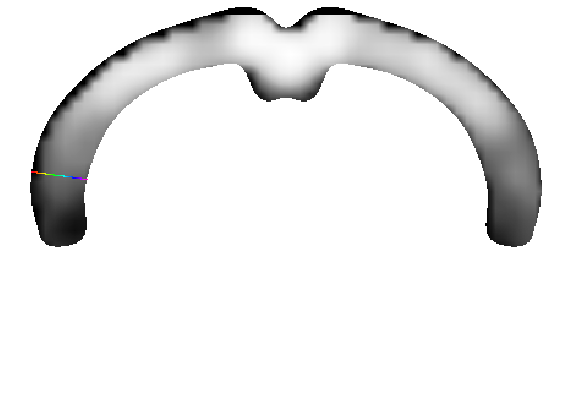

In [27]:
x = 315
fig = plt.figure(figsize=(10,10))
plt.imshow(data[x, :, :], cmap='Greys');
plt.imshow(test[x, :, :], cmap='gist_rainbow');
plt.axis('off')

### Loop over all points

In [8]:
mesh_data = np.zeros(len(mesh["points"]))
qa_voxels = []

for p in range(len(mesh["points"])):
    sample = []
    voxels = []
    first_round = True
    
    point = mesh["points"][p]

    while True:
        if first_round is True:
            voxel = np.array(np.floor(point/25), dtype="int16")
            same_voxel = False
            first_round = False
        else: 
            # move forward
            point = point - normals[p]
            voxel = np.array(np.floor(point/25), dtype="int16")
            # check if this is a new voxel
            same_voxel = np.all(voxels[-1]==voxel)

        if same_voxel == False:
            # check that voxel is still in image
            try:
                value = data[voxel[0], voxel[1], voxel[2]]
            except IndexError:
                break

            # when outside the cortex mask
            if np.isnan(value) == True:
                # allow to go on for a few voxels in the beginning
                if len(voxels) < 5:
                    pass
                # if the nan occurs later, stop sampling
                else:
                    break
            # if inside mask, sample value
            else:
                sample.append(value)
            voxels.append(voxel)
            
            if len(voxels) >=50:
                break

    mesh_data[p] = np.nanmean(sample)
    qa_voxels.append(voxels)

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


In [24]:
with open('/home/julia/data/gradients/results/qa_voxels.pkl', 'wb') as filehandle:
    pickle.dump(qa_voxels, filehandle)

In [9]:
mesh_data = np.nan_to_num(mesh_data)

In [10]:
np.save("/home/julia/data/gradients/results/gradient0000_mesh.npy", mesh_data)

In [11]:
mesh['data']=mesh_data

In [12]:
io.save_mesh("/home/julia/data/gradients/results/gradient0000_mesh.vtk", mesh)

### QA: Plotting trajectories

In [20]:
qa = np.zeros_like(data)
for p in range(len(mesh["points"])):
    profile = qa_voxels[p]
    if len(profile) > 5:
        for v in range(len(profile)):
            vox = profile[v]
            qa[vox[0], vox[1], vox[2]] = v+1
qa[qa==0]=np.nan

In [23]:
len(qa_voxels)

49324

In [21]:
np.save("/home/julia/data/gradients/results/qa.npy", qa)
aff = nb.load("/home/julia/data/gradients/results/gradient0000_highres_allen.nii.gz").affine
nb.save(nb.Nifti1Image(np.nan_to_num(qa), aff), "/home/julia/data/gradients/results/qa.nii.gz")

(-0.5, 455.5, 319.5, -0.5)

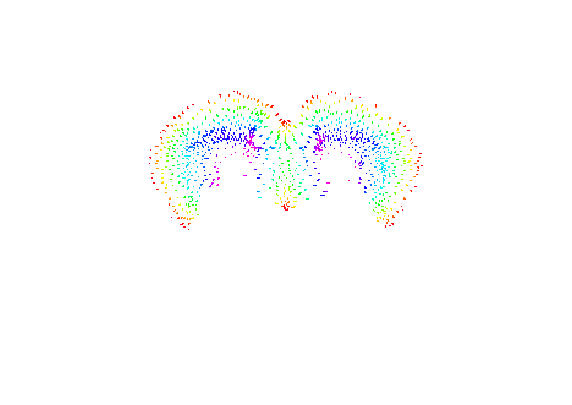

In [22]:
x = 100
fig = plt.figure(figsize=(10,10))
plt.imshow(qa[x, :, :], cmap='gist_rainbow');
plt.axis('off')

In [112]:
profile_length = []
for p in range(len(mesh["points"])):
    profile_length.append(len(qa_voxels[p]))
profile_length=np.asarray(profile_length)

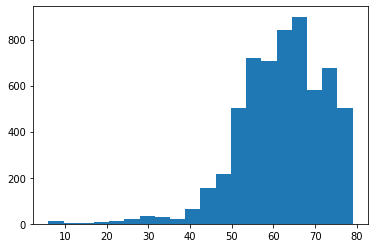

In [120]:
plt.hist(profile_length[(profile_length>5) & (profile_length<80)], bins=20);

In [121]:
profile_length[(profile_length<=5)]=0
profile_length[(profile_length>80)]=0

In [122]:
mesh['data']=np.asarray(profile_length)
io.save_mesh("/home/julia/data/gradients/results/profile_len.vtk", mesh)

### QA: Sampling annot volume